# RT-DETR Multi-Backbone Comparison and Visualization

This notebook loads training results from individual model training notebooks and provides:
- Dataset visualization with polygon annotations
- Model comparison (accuracy, inference time, training time)
- Confusion matrices for all models
- Per-class F1 score comparison
- Summary report

## Prerequisites
Run the training notebooks first:
1. `Train_RT-DETR_ShuffleNet.ipynb`
2. `Train_RT-DETR_MobileNet.ipynb`
3. `Train_RT-DETR_L.ipynb`
4. `Train_RT-DETR_X.ipynb`

## 1. Setup and Imports

In [1]:
%matplotlib inline

import os
import json
import random
from glob import glob

import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon

from sklearn.metrics import classification_report
import seaborn as sns

# Ensure plots display properly in Jupyter
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

print("Imports loaded successfully!")

Imports loaded successfully!


## 2. Configuration

In [2]:
# =============================================================================
# PATHS CONFIGURATION
# =============================================================================
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.join(NOTEBOOK_DIR, "output")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

# Dataset path
DATA_ROOT = r"C:\D drive\mydata\MSML\DataSets\Raabin_datsets_withlabels"
IMAGES_DIR = os.path.join(DATA_ROOT, "Train", "images")
LABELS_DIR = os.path.join(DATA_ROOT, "Train", "labels")

# Class definitions
CLASSES = {
    "Basophil": 0,
    "Eosinophil": 1,
    "Lymphocyte": 2,
    "Monocyte": 3,
    "Neutrophil": 4
}
ID2LABEL = {v: k for k, v in CLASSES.items()}
NUM_CLASSES = len(CLASSES)

# Expected result files
MODEL_NAMES = [
    "RT-DETR-ShuffleNet",
    "RT-DETR-MobileNet",
    "RT-DETR-L",
    "RT-DETR-X"
]

print(f"Results directory: {RESULTS_DIR}")
print(f"Data root: {DATA_ROOT}")

Results directory: C:\D drive\mydata\MSML\GitHub\RT-DETR-Based-Explainable-CAD-System-for-Automated-Detection-and-Classification-of-White-Blood-Cells\output\results
Data root: C:\D drive\mydata\MSML\DataSets\Raabin_datsets_withlabels


## 3. Load Results from Training Notebooks

In [3]:
def load_all_results(results_dir, model_names):
    """
    Load results JSON files from all trained models.
    """
    all_results = []
    missing_models = []
    
    for model_name in model_names:
        results_file = os.path.join(results_dir, f"{model_name}_results.json")
        
        if os.path.exists(results_file):
            with open(results_file, 'r') as f:
                result = json.load(f)
            all_results.append(result)
            epochs = result.get('total_epochs', 'N/A')
            print(f"Loaded: {model_name} (Accuracy: {result['accuracy']:.4f}, Epochs: {epochs})")
        else:
            missing_models.append(model_name)
            print(f"WARNING: Results not found for {model_name}")
    
    if missing_models:
        print(f"\nMissing models: {missing_models}")
        print("Please run the corresponding training notebooks first.")
    
    return all_results

# Load all results
print("Loading results from training notebooks...\n")
evaluation_results = load_all_results(RESULTS_DIR, MODEL_NAMES)

print(f"\nLoaded {len(evaluation_results)} model results.")

Loading results from training notebooks...

Loaded: RT-DETR-ShuffleNet (Accuracy: 0.9320, Epochs: 15)
Loaded: RT-DETR-MobileNet (Accuracy: 0.9440, Epochs: 15)
Loaded: RT-DETR-L (Accuracy: 0.9680, Epochs: 5)
Loaded: RT-DETR-X (Accuracy: 0.9140, Epochs: 5)

Loaded 4 model results.


## 4. Visualize Dataset with Polygon Annotations

In [4]:
def visualize_polygon_annotations(images_dir, labels_dir, classes, samples_per_class=3, random_seed=42):
    """
    Visualize polygon segmentation annotations overlaid on images.
    Green = polygon outline, Red dashed = bounding box derived from polygon
    """
    if random_seed is not None:
        random.seed(random_seed)
    
    for cls_name in classes:
        img_cls_dir = os.path.join(images_dir, cls_name)
        lbl_cls_dir = os.path.join(labels_dir, cls_name)
        
        if not os.path.exists(img_cls_dir) or not os.path.exists(lbl_cls_dir):
            print(f"Warning: Directory not found for {cls_name}")
            continue
        
        # Get image files that have matching label files
        image_files = [f for f in os.listdir(img_cls_dir) if f.lower().endswith(".jpg")]
        valid_files = []
        for f in image_files:
            lbl_file = f.replace('.jpg', '.txt').replace('.JPG', '.txt')
            if os.path.exists(os.path.join(lbl_cls_dir, lbl_file)):
                valid_files.append(f)
        
        # Sample random files
        sample_files = random.sample(valid_files, min(samples_per_class, len(valid_files)))
        
        print(f"\n{'='*60}")
        print(f"Class: {cls_name}")
        print(f"{'='*60}")
        
        fig, axes = plt.subplots(1, len(sample_files), figsize=(6*len(sample_files), 6))
        if len(sample_files) == 1:
            axes = [axes]
        
        for idx, img_file in enumerate(sample_files):
            img_path = os.path.join(img_cls_dir, img_file)
            lbl_file = img_file.replace('.jpg', '.txt').replace('.JPG', '.txt')
            lbl_path = os.path.join(lbl_cls_dir, lbl_file)
            
            # Load image
            img = Image.open(img_path).convert("RGB")
            w, h = img.size
            
            # Load polygon annotation
            with open(lbl_path, 'r') as f:
                line = f.readline().strip()
            
            ax = axes[idx]
            ax.imshow(img)
            ax.set_title(f"{img_file}\n({w}x{h})", fontsize=10)
            ax.axis("off")
            
            if line:
                parts = line.split()
                coords = [float(x) for x in parts[1:]]
                
                # Convert normalized coords to pixel coords
                x_coords = [coords[i] * w for i in range(0, len(coords), 2)]
                y_coords = [coords[i] * h for i in range(1, len(coords), 2)]
                
                # Create polygon
                polygon_pts = list(zip(x_coords, y_coords))
                polygon = Polygon(polygon_pts, closed=True, fill=False, 
                                  edgecolor='lime', linewidth=2)
                ax.add_patch(polygon)
                
                # Draw bounding box from polygon
                x_min, x_max = min(x_coords), max(x_coords)
                y_min, y_max = min(y_coords), max(y_coords)
                rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min,
                                         linewidth=2, edgecolor='red', facecolor='none',
                                         linestyle='--')
                ax.add_patch(rect)
                
                # Add legend
                ax.text(5, 20, f"Polygon (green)", color='lime', fontsize=9, 
                       backgroundcolor='black')
                ax.text(5, 40, f"BBox (red dashed)", color='red', fontsize=9,
                       backgroundcolor='black')
        
        plt.tight_layout()
        plt.show()

Visualizing polygon segmentation annotations for each class...
Green = polygon outline, Red dashed = bounding box derived from polygon


Class: Basophil


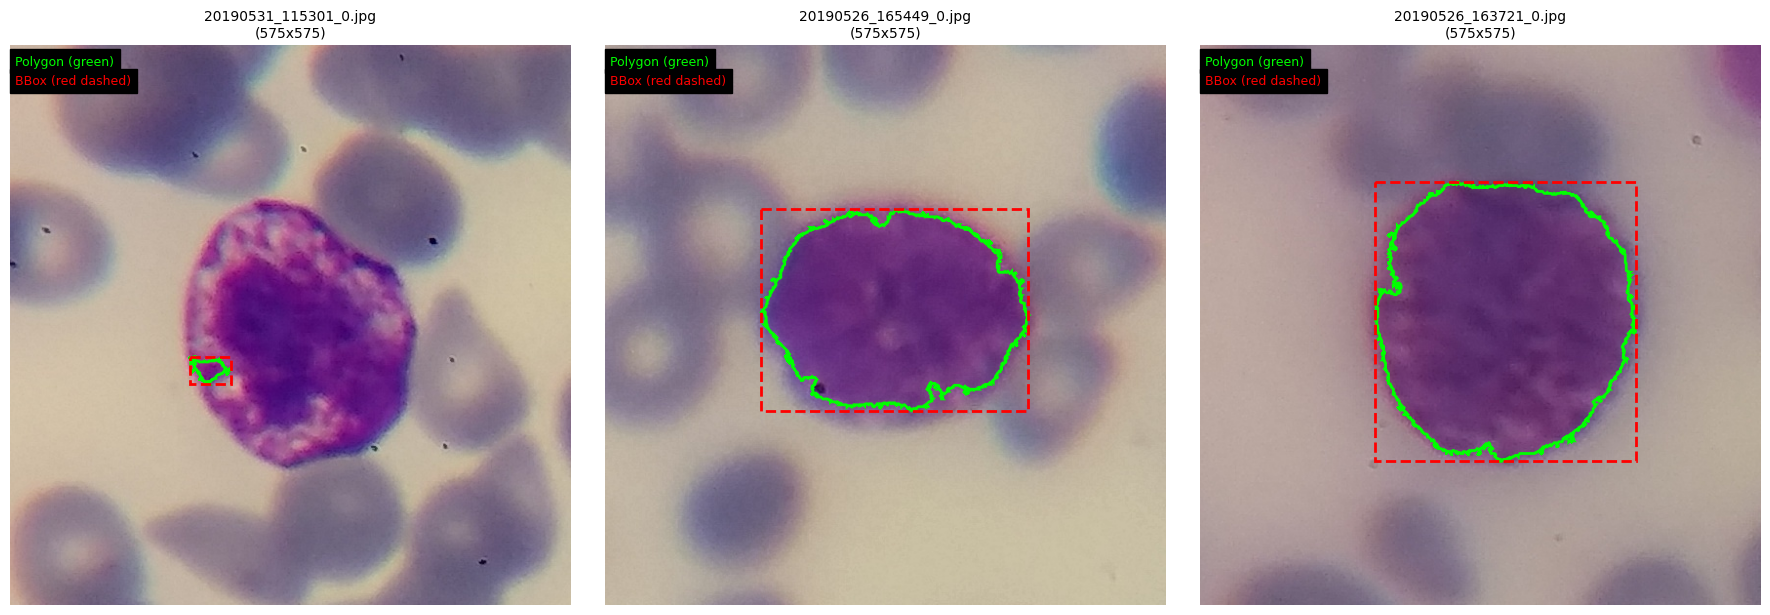


Class: Eosinophil


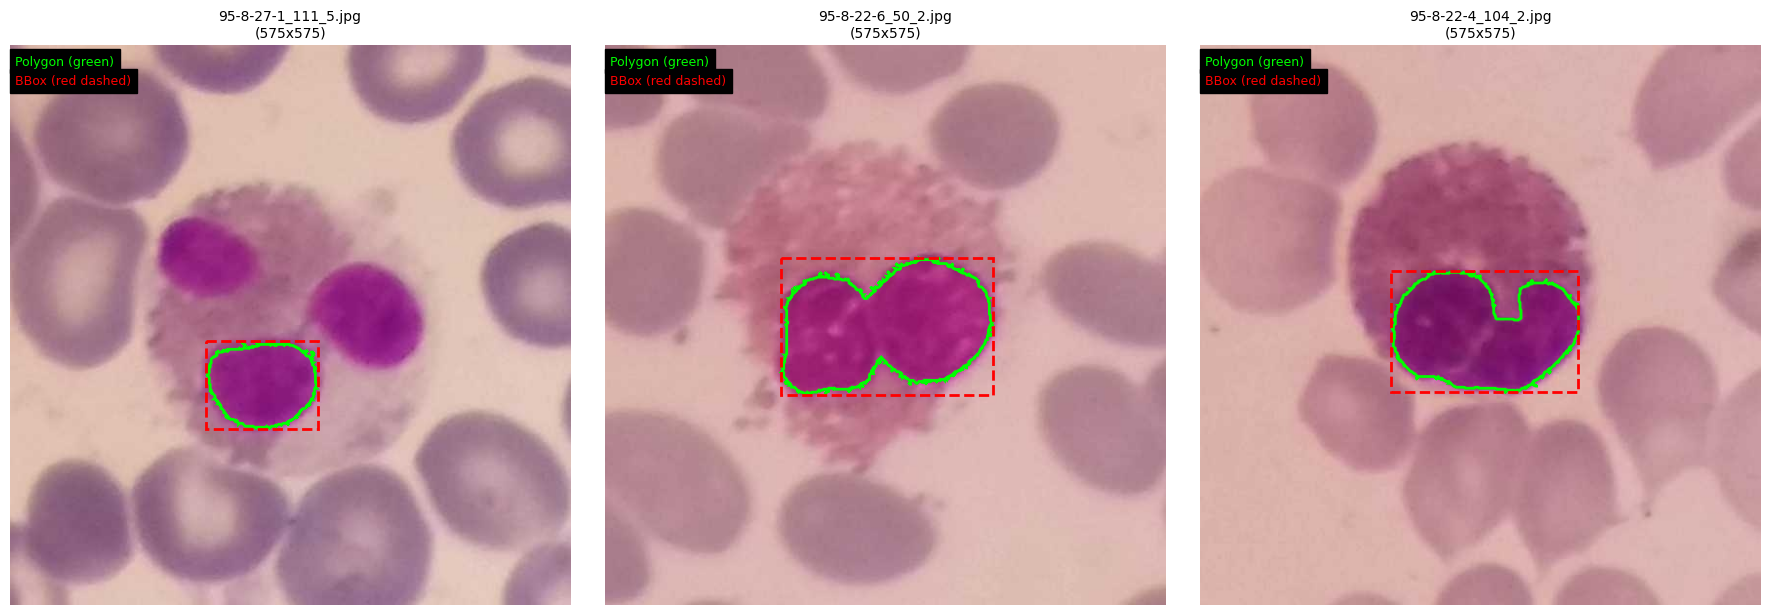


Class: Lymphocyte


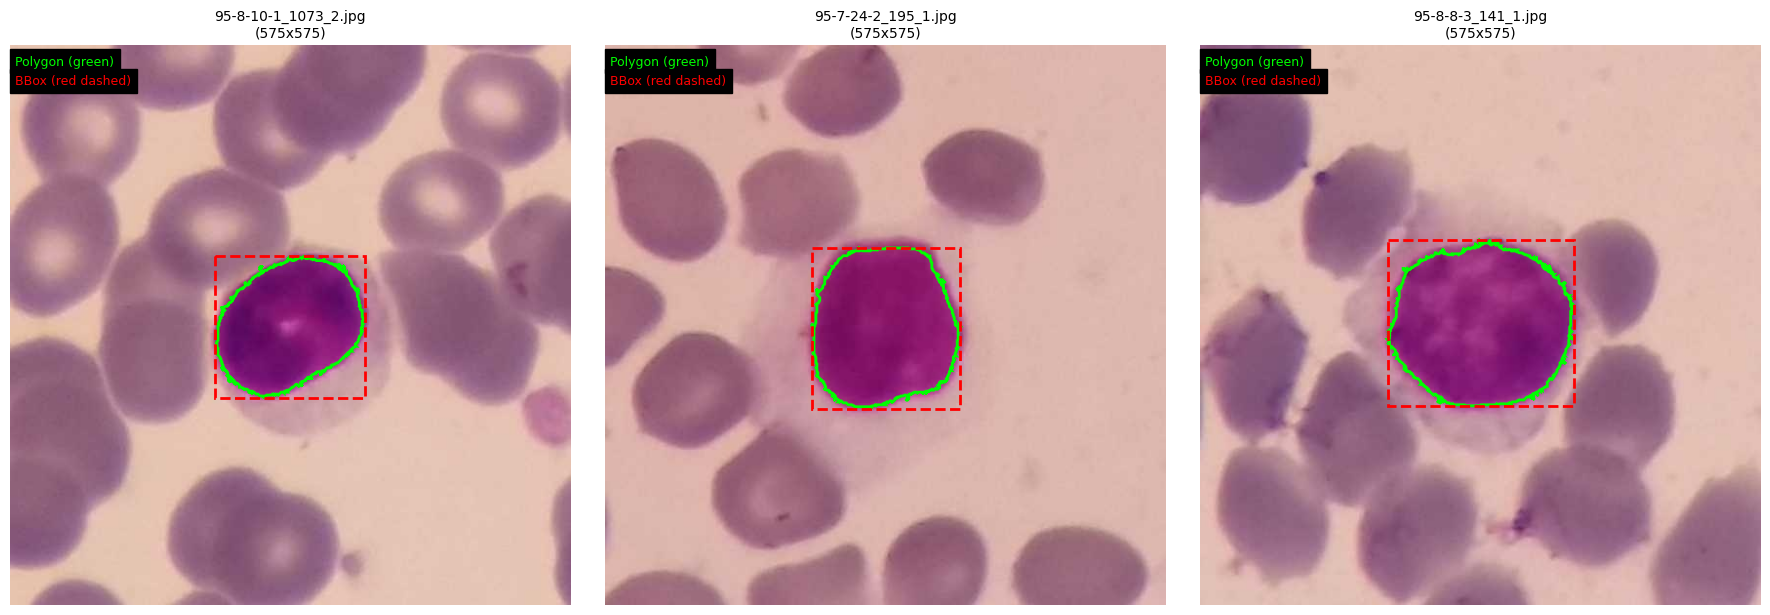


Class: Monocyte


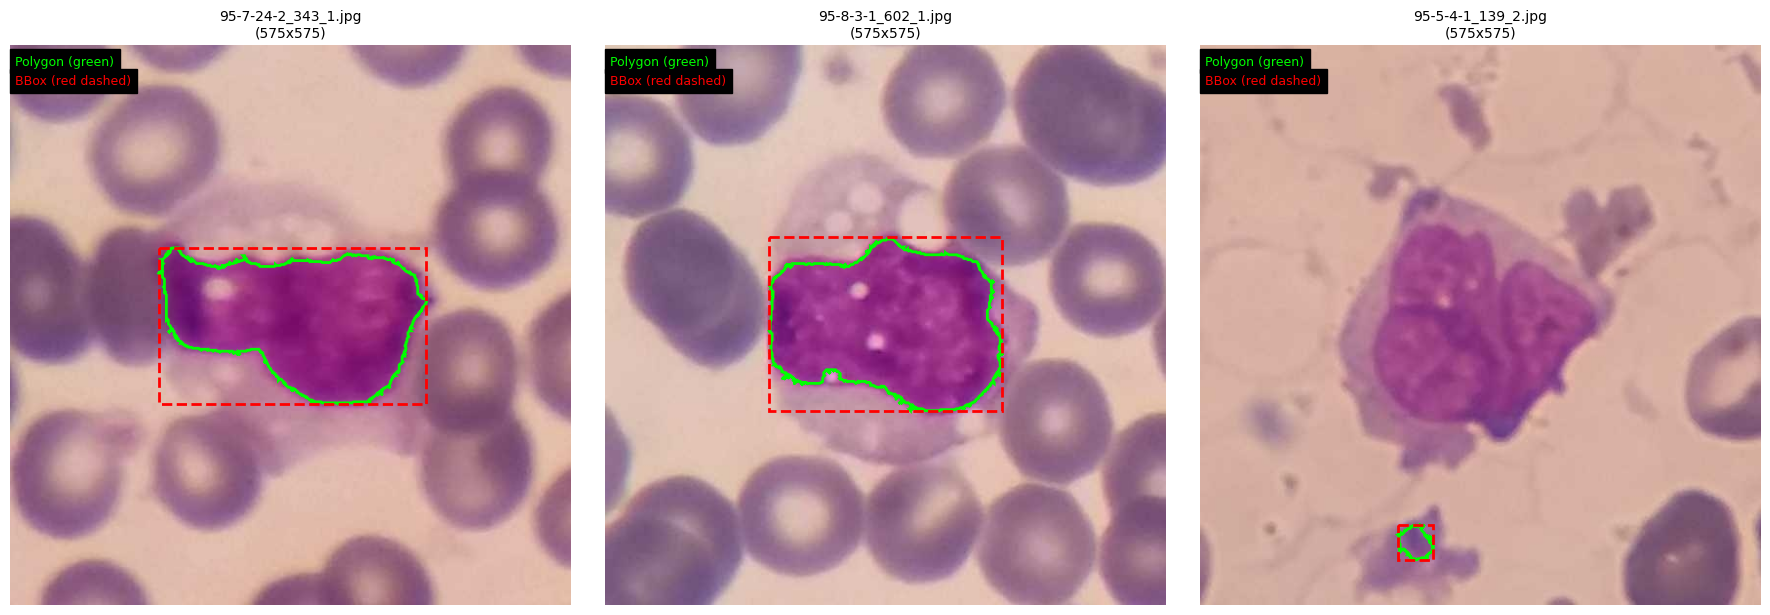


Class: Neutrophil


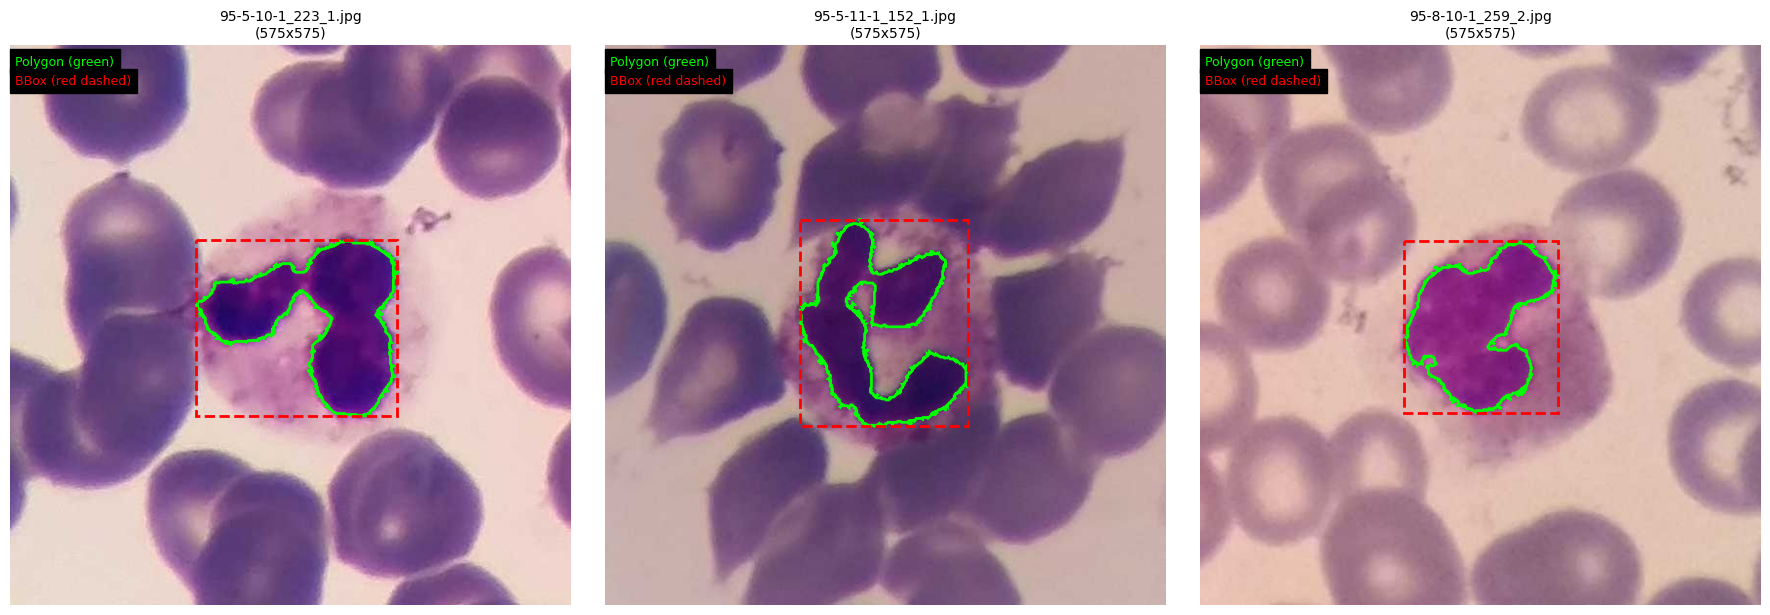

In [5]:
# Visualize polygon annotations for all classes
print("Visualizing polygon segmentation annotations for each class...")
print("Green = polygon outline, Red dashed = bounding box derived from polygon\n")
visualize_polygon_annotations(IMAGES_DIR, LABELS_DIR, list(CLASSES.keys()), samples_per_class=3)

## 5. Visualize Random Samples with Bounding Boxes

In [6]:
def parse_yolo_polygon(label_path, img_width, img_height):
    """
    Parse YOLO polygon annotation and extract bounding box.
    """
    with open(label_path, 'r') as f:
        line = f.readline().strip()

    if not line:
        return [int(0.1 * img_width), int(0.1 * img_height),
                int(0.8 * img_width), int(0.8 * img_height)]

    parts = line.split()
    coords = [float(x) for x in parts[1:]]

    x_coords = [coords[i] for i in range(0, len(coords), 2)]
    y_coords = [coords[i] for i in range(1, len(coords), 2)]

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x = int(x_min * img_width)
    y = int(y_min * img_height)
    w = int((x_max - x_min) * img_width)
    h = int((y_max - y_min) * img_height)

    return [x, y, w, h]


def visualize_samples(images_dir, labels_dir, classes, n=5, random_seed=None):
    """
    Visualize random samples with bounding boxes from each class.
    """
    if random_seed is not None:
        random.seed(random_seed)

    all_samples = []
    for cls_name, cls_id in classes.items():
        img_cls_dir = os.path.join(images_dir, cls_name)
        lbl_cls_dir = os.path.join(labels_dir, cls_name)
        
        if not os.path.exists(img_cls_dir):
            continue
            
        image_files = [f for f in os.listdir(img_cls_dir) if f.lower().endswith(".jpg")]
        for img_file in image_files:
            lbl_file = img_file.replace('.jpg', '.txt').replace('.JPG', '.txt')
            if os.path.exists(os.path.join(lbl_cls_dir, lbl_file)):
                all_samples.append({
                    "img_path": os.path.join(img_cls_dir, img_file),
                    "lbl_path": os.path.join(lbl_cls_dir, lbl_file),
                    "class_name": cls_name,
                    "class_id": cls_id
                })
    
    samples = random.sample(all_samples, min(n, len(all_samples)))

    for sample in samples:
        img = Image.open(sample["img_path"]).convert("RGB")
        img_width, img_height = img.size
        box = parse_yolo_polygon(sample["lbl_path"], img_width, img_height)
        x, y, w, h = box
        label = sample["class_name"]

        fig, ax = plt.subplots(1, figsize=(6, 6))
        ax.imshow(img)
        ax.axis("off")

        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(x, y - 5, label, color="red", fontsize=12, backgroundcolor="white")
        ax.set_title(f"Sample: {label}")
        plt.show()

Visualizing random samples with bounding boxes...



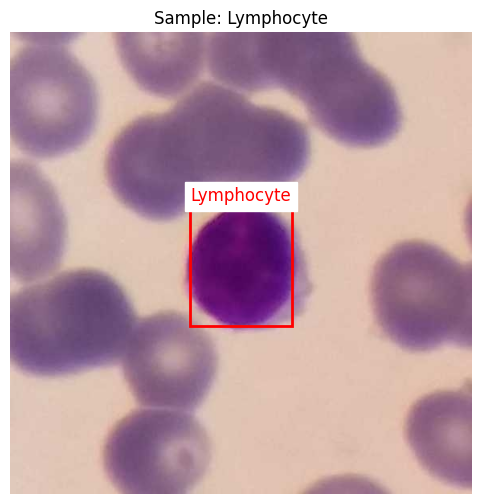

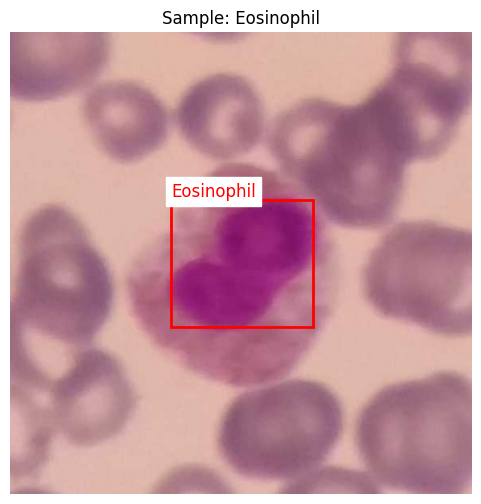

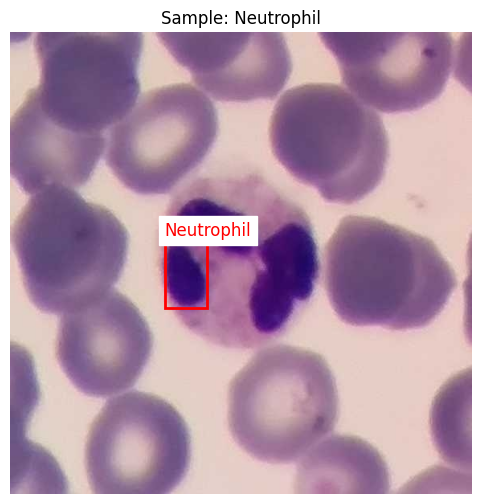

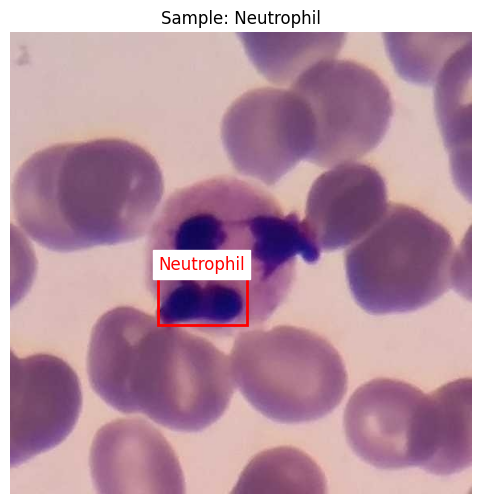

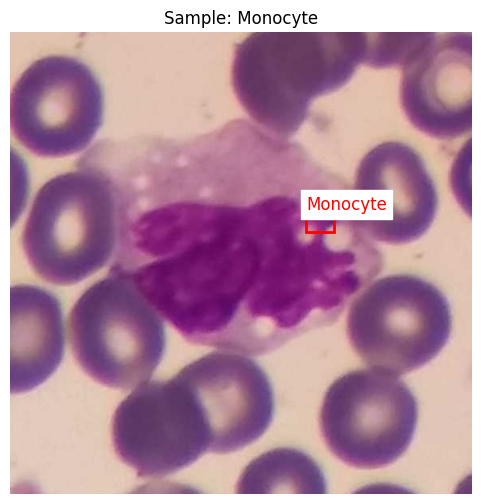

In [7]:
# Visualize random samples with bounding boxes
print("Visualizing random samples with bounding boxes...\n")
visualize_samples(IMAGES_DIR, LABELS_DIR, CLASSES, n=5, random_seed=42)

## 6. Model Comparison Table

In [8]:
if len(evaluation_results) > 0:
    # Create comparison table
    print("\n" + "="*95)
    print("MODEL COMPARISON RESULTS")
    print("="*95)
    print(f"{'Model':<20} {'Backbone':<18} {'Epochs':<8} {'Accuracy':<12} {'Inference (ms)':<16} {'Training (s)':<12}")
    print("-"*95)

    for result in evaluation_results:
        epochs = result.get('total_epochs', 'N/A')
        print(f"{result['model_name']:<20} {result['backbone']:<18} {epochs:<8} {result['accuracy']:.4f}       {result['avg_inference_time_ms']:.2f}            {result['training_time_s']:.1f}")

    print("="*95)
else:
    print("No results to display. Please run the training notebooks first.")


MODEL COMPARISON RESULTS
Model                Backbone           Epochs   Accuracy     Inference (ms)   Training (s)
-----------------------------------------------------------------------------------------------
RT-DETR-ShuffleNet   ShuffleNetV2-Small 15       0.9320       26.54            1517.7
RT-DETR-MobileNet    MobileNetV3-Small  15       0.9440       26.46            1535.6
RT-DETR-L            ResNet-50          5        0.9680       40.57            1300.4
RT-DETR-X            ResNet-101         5        0.9140       48.73            3152.4


## 7. Comparison Bar Charts

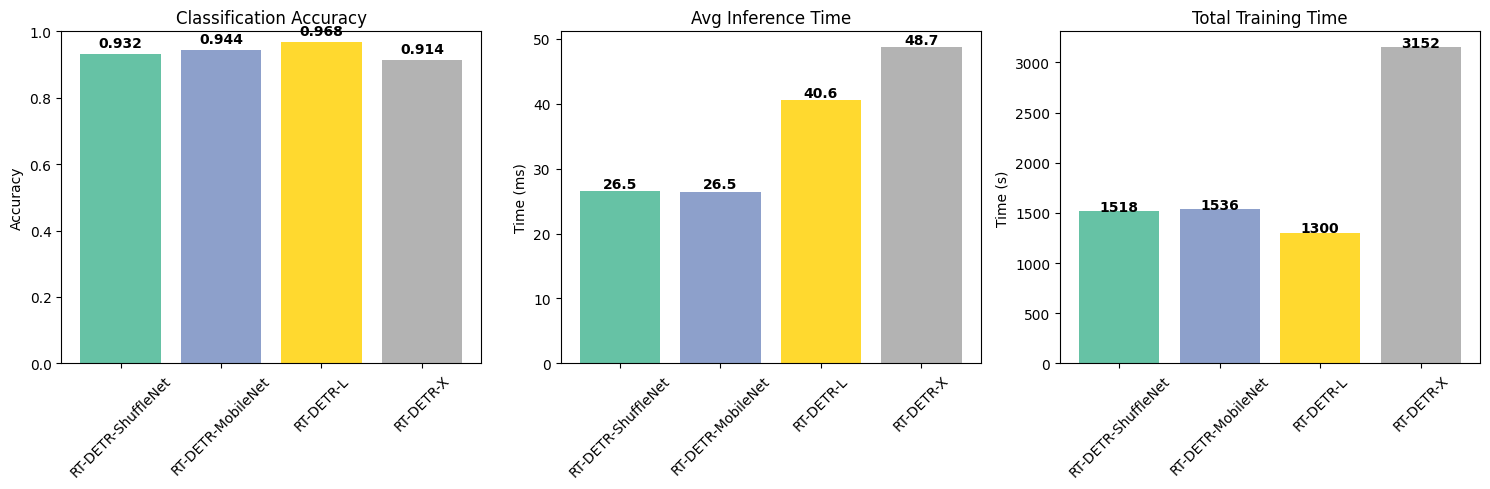

Saved: C:\D drive\mydata\MSML\GitHub\RT-DETR-Based-Explainable-CAD-System-for-Automated-Detection-and-Classification-of-White-Blood-Cells\output\results\model_comparison.png


In [9]:
if len(evaluation_results) > 0:
    # Visualization: Accuracy Comparison Bar Chart
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    model_names = [r["model_name"] for r in evaluation_results]
    accuracies = [r["accuracy"] for r in evaluation_results]
    inference_times = [r["avg_inference_time_ms"] for r in evaluation_results]
    training_times = [r["training_time_s"] for r in evaluation_results]

    # Use a color palette that works for any number of models
    colors = plt.cm.Set2(np.linspace(0, 1, len(evaluation_results)))

    # Accuracy
    axes[0].bar(model_names, accuracies, color=colors)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Classification Accuracy')
    axes[0].set_ylim(0, 1)
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

    # Inference Time
    axes[1].bar(model_names, inference_times, color=colors)
    axes[1].set_ylabel('Time (ms)')
    axes[1].set_title('Avg Inference Time')
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(inference_times):
        axes[1].text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

    # Training Time
    axes[2].bar(model_names, training_times, color=colors)
    axes[2].set_ylabel('Time (s)')
    axes[2].set_title('Total Training Time')
    axes[2].tick_params(axis='x', rotation=45)
    for i, v in enumerate(training_times):
        axes[2].text(i, v + 5, f'{v:.0f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'model_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {os.path.join(RESULTS_DIR, 'model_comparison.png')}")
else:
    print("No results to display.")

## 8. Confusion Matrices

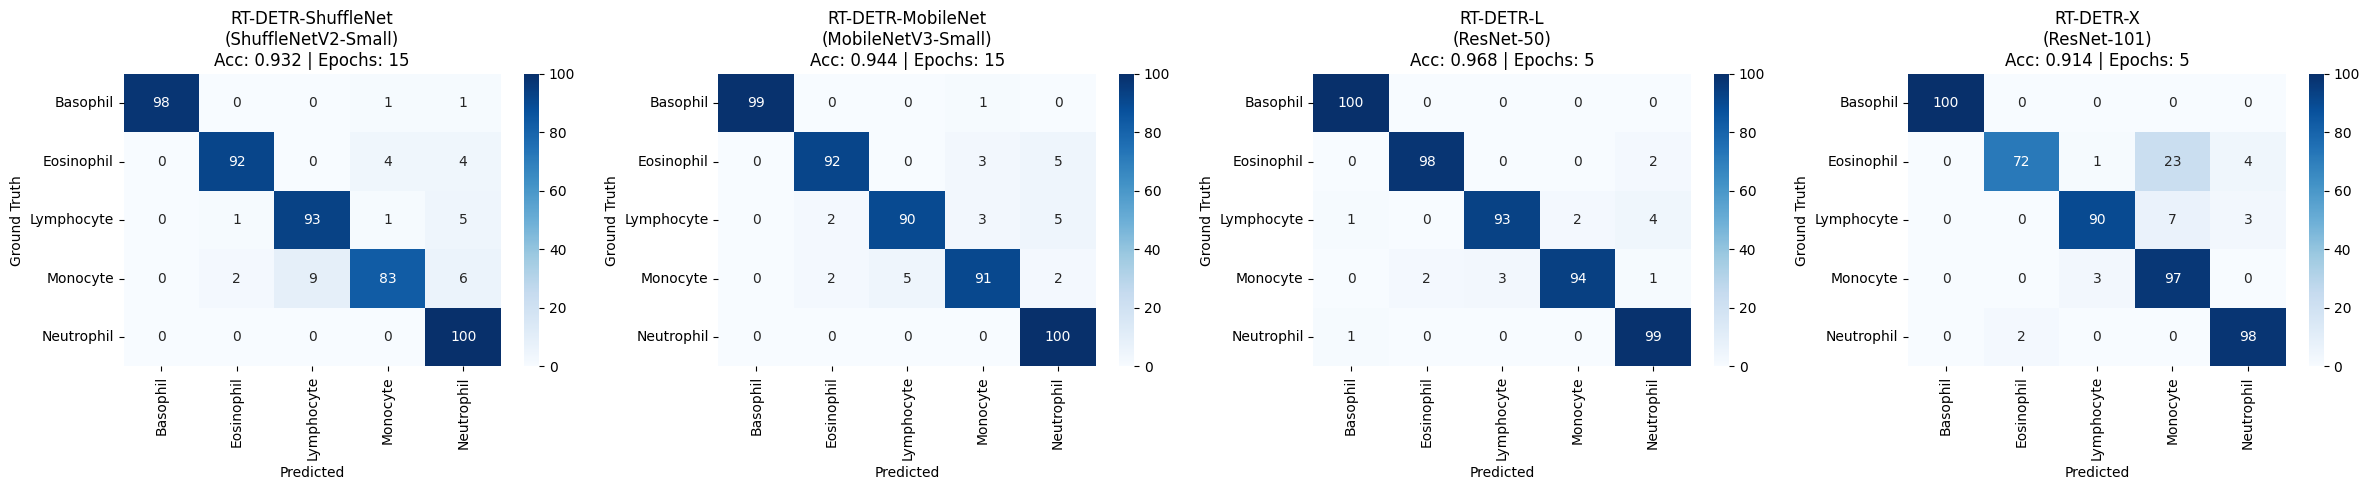

Saved: C:\D drive\mydata\MSML\GitHub\RT-DETR-Based-Explainable-CAD-System-for-Automated-Detection-and-Classification-of-White-Blood-Cells\output\results\confusion_matrices.png


In [10]:
if len(evaluation_results) > 0:
    # Confusion Matrices for all models
    n_models = len(evaluation_results)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    if n_models == 1:
        axes = [axes]

    for idx, result in enumerate(evaluation_results):
        if result["confusion_matrix"] is not None:
            cm = np.array(result["confusion_matrix"])
            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                xticklabels=CLASSES.keys(),
                yticklabels=CLASSES.keys(),
                cmap="Blues",
                ax=axes[idx]
            )
            axes[idx].set_xlabel("Predicted")
            axes[idx].set_ylabel("Ground Truth")
            epochs = result.get('total_epochs', 'N/A')
            axes[idx].set_title(f"{result['model_name']}\n({result['backbone']})\nAcc: {result['accuracy']:.3f} | Epochs: {epochs}")

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {os.path.join(RESULTS_DIR, 'confusion_matrices.png')}")
else:
    print("No results to display.")

## 9. Per-Class F1 Score Comparison

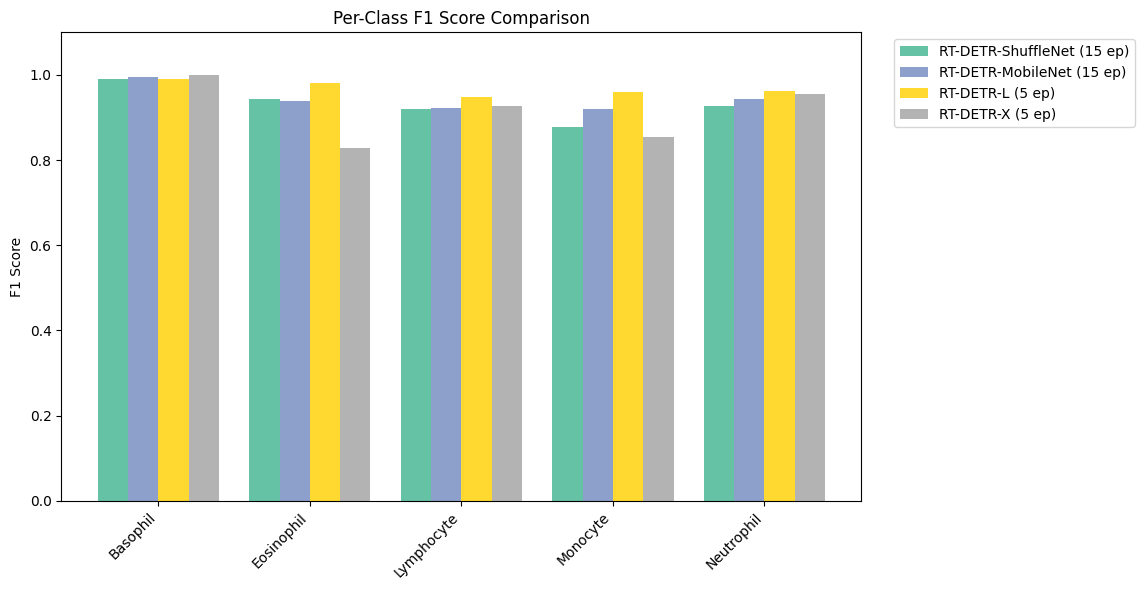

Saved: C:\D drive\mydata\MSML\GitHub\RT-DETR-Based-Explainable-CAD-System-for-Automated-Detection-and-Classification-of-White-Blood-Cells\output\results\f1_comparison.png


In [11]:
if len(evaluation_results) > 0:
    # Per-class F1 scores comparison
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(CLASSES))
    width = 0.8 / len(evaluation_results)
    colors = plt.cm.Set2(np.linspace(0, 1, len(evaluation_results)))

    for idx, result in enumerate(evaluation_results):
        if result["classification_report"] is not None:
            f1_scores = [result["classification_report"][cls]["f1-score"] for cls in CLASSES.keys()]
            offset = (idx - len(evaluation_results)/2 + 0.5) * width
            epochs = result.get('total_epochs', 'N/A')
            ax.bar(x + offset, f1_scores, width, 
                   label=f"{result['model_name']} ({epochs} ep)", 
                   color=colors[idx])

    ax.set_ylabel('F1 Score')
    ax.set_title('Per-Class F1 Score Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(CLASSES.keys(), rotation=45, ha='right')
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
    ax.set_ylim(0, 1.1)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'f1_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {os.path.join(RESULTS_DIR, 'f1_comparison.png')}")
else:
    print("No results to display.")

## 10. Detailed Classification Reports

In [12]:
if len(evaluation_results) > 0:
    print("\n" + "="*80)
    print("DETAILED CLASSIFICATION REPORTS")
    print("="*80)

    for result in evaluation_results:
        epochs = result.get('total_epochs', 'N/A')
        print(f"\n--- {result['model_name']} ({result['backbone']}) | {epochs} epochs ---")
        if result["classification_report"] is not None:
            y_true = np.array(result["y_true"])
            y_pred = np.array(result["y_pred"])
            valid = y_pred != -1
            
            print(classification_report(
                y_true[valid],
                y_pred[valid],
                target_names=list(CLASSES.keys()),
                labels=list(range(NUM_CLASSES)),
                zero_division=0
            ))
        print(f"No predictions: {result['no_prediction_count']}/{result['total_samples']}")
else:
    print("No results to display.")


DETAILED CLASSIFICATION REPORTS

--- RT-DETR-ShuffleNet (ShuffleNetV2-Small) | 15 epochs ---
              precision    recall  f1-score   support

    Basophil       1.00      0.98      0.99       100
  Eosinophil       0.97      0.92      0.94       100
  Lymphocyte       0.91      0.93      0.92       100
    Monocyte       0.93      0.83      0.88       100
  Neutrophil       0.86      1.00      0.93       100

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500

No predictions: 0/500

--- RT-DETR-MobileNet (MobileNetV3-Small) | 15 epochs ---
              precision    recall  f1-score   support

    Basophil       1.00      0.99      0.99       100
  Eosinophil       0.96      0.92      0.94       100
  Lymphocyte       0.95      0.90      0.92       100
    Monocyte       0.93      0.91      0.92       100
  Neutrophil       0.89      1.00      0.94       100

    accura

## 11. Summary and Conclusions

In [13]:
if len(evaluation_results) > 0:
    # Save combined results to JSON
    combined_results = []
    for result in evaluation_results:
        combined_results.append({
            "model_name": result["model_name"],
            "backbone": result["backbone"],
            "is_pretrained": result.get("is_pretrained", False),
            "total_epochs": result.get("total_epochs", "N/A"),
            "accuracy": float(result["accuracy"]),
            "avg_inference_time_ms": float(result["avg_inference_time_ms"]),
            "training_time_s": float(result["training_time_s"]),
            "no_prediction_count": int(result["no_prediction_count"]),
            "total_samples": int(result["total_samples"]),
        })

    with open(os.path.join(RESULTS_DIR, 'comparison_results.json'), 'w') as f:
        json.dump(combined_results, f, indent=2)

    print(f"Results saved to: {RESULTS_DIR}/comparison_results.json")

Results saved to: C:\D drive\mydata\MSML\GitHub\RT-DETR-Based-Explainable-CAD-System-for-Automated-Detection-and-Classification-of-White-Blood-Cells\output\results/comparison_results.json


In [14]:
if len(evaluation_results) > 0:
    # Find best model
    best_accuracy = max(evaluation_results, key=lambda x: x["accuracy"])
    fastest_inference = min(evaluation_results, key=lambda x: x["avg_inference_time_ms"])

    print("\n" + "="*80)
    print("CONCLUSIONS")
    print("="*80)
    print(f"\nBest Accuracy: {best_accuracy['model_name']} ({best_accuracy['backbone']})")
    print(f"  -> {best_accuracy['accuracy']:.4f} ({best_accuracy.get('total_epochs', 'N/A')} epochs)")

    print(f"\nFastest Inference: {fastest_inference['model_name']} ({fastest_inference['backbone']})")
    print(f"  -> {fastest_inference['avg_inference_time_ms']:.2f}ms per image")

    # Additional insights
    print("\n" + "-"*80)
    print("MODEL RANKINGS")
    print("-"*80)
    
    print("\nBy Accuracy (descending):")
    sorted_by_acc = sorted(evaluation_results, key=lambda x: x["accuracy"], reverse=True)
    for i, r in enumerate(sorted_by_acc, 1):
        epochs = r.get('total_epochs', 'N/A')
        print(f"  {i}. {r['model_name']}: {r['accuracy']:.4f} ({epochs} epochs)")
    
    print("\nBy Inference Speed (ascending):")
    sorted_by_speed = sorted(evaluation_results, key=lambda x: x["avg_inference_time_ms"])
    for i, r in enumerate(sorted_by_speed, 1):
        print(f"  {i}. {r['model_name']}: {r['avg_inference_time_ms']:.2f}ms")
    
    print("\nBy Training Time (ascending):")
    sorted_by_training = sorted(evaluation_results, key=lambda x: x["training_time_s"])
    for i, r in enumerate(sorted_by_training, 1):
        epochs = r.get('total_epochs', 'N/A')
        print(f"  {i}. {r['model_name']}: {r['training_time_s']:.1f}s ({epochs} epochs)")

    print("\n" + "="*80)
else:
    print("No results to analyze. Please run the training notebooks first.")


CONCLUSIONS

Best Accuracy: RT-DETR-L (ResNet-50)
  -> 0.9680 (5 epochs)

Fastest Inference: RT-DETR-MobileNet (MobileNetV3-Small)
  -> 26.46ms per image

--------------------------------------------------------------------------------
MODEL RANKINGS
--------------------------------------------------------------------------------

By Accuracy (descending):
  1. RT-DETR-L: 0.9680 (5 epochs)
  2. RT-DETR-MobileNet: 0.9440 (15 epochs)
  3. RT-DETR-ShuffleNet: 0.9320 (15 epochs)
  4. RT-DETR-X: 0.9140 (5 epochs)

By Inference Speed (ascending):
  1. RT-DETR-MobileNet: 26.46ms
  2. RT-DETR-ShuffleNet: 26.54ms
  3. RT-DETR-L: 40.57ms
  4. RT-DETR-X: 48.73ms

By Training Time (ascending):
  1. RT-DETR-L: 1300.4s (5 epochs)
  2. RT-DETR-ShuffleNet: 1517.7s (15 epochs)
  3. RT-DETR-MobileNet: 1535.6s (15 epochs)
  4. RT-DETR-X: 3152.4s (5 epochs)



## 12. Summary Table Export

In [15]:
if len(evaluation_results) > 0:
    # Create a summary DataFrame-like table for easy export
    print("\n" + "="*115)
    print("SUMMARY TABLE (Copy-Paste Friendly)")
    print("="*115)
    
    # Header
    print(f"{'Model':<22} | {'Backbone':<18} | {'Pretrained':<10} | {'Epochs':<8} | {'Accuracy':<10} | {'Inference (ms)':<14} | {'Training (s)':<12}")
    print("-"*115)
    
    for result in evaluation_results:
        pretrained = "Yes" if result.get("is_pretrained", False) else "No"
        epochs = result.get('total_epochs', 'N/A')
        print(f"{result['model_name']:<22} | {result['backbone']:<18} | {pretrained:<10} | {epochs:<8} | {result['accuracy']:.4f}     | {result['avg_inference_time_ms']:.2f}          | {result['training_time_s']:.1f}")
    
    print("="*115)
else:
    print("No results to display.")


SUMMARY TABLE (Copy-Paste Friendly)
Model                  | Backbone           | Pretrained | Epochs   | Accuracy   | Inference (ms) | Training (s)
-------------------------------------------------------------------------------------------------------------------
RT-DETR-ShuffleNet     | ShuffleNetV2-Small | No         | 15       | 0.9320     | 26.54          | 1517.7
RT-DETR-MobileNet      | MobileNetV3-Small  | No         | 15       | 0.9440     | 26.46          | 1535.6
RT-DETR-L              | ResNet-50          | Yes        | 5        | 0.9680     | 40.57          | 1300.4
RT-DETR-X              | ResNet-101         | Yes        | 5        | 0.9140     | 48.73          | 3152.4


## 13. Explainability Analysis — GradCAM and ScoreCAM

To ensure transparency and build clinical trust in the model's predictions, two Class Activation Mapping (CAM) techniques are used to visualise which regions of the input image most influenced the model's classification decision.

- **GradCAM** (Gradient-weighted Class Activation Mapping): Uses gradients of the predicted class score flowing back into the last backbone feature maps. The gradients are globally average-pooled to obtain channel importance weights, and the weighted sum of activation maps (passed through ReLU) produces the saliency heatmap.

- **ScoreCAM** (Score-weighted Class Activation Mapping): A gradient-free alternative. Each activation map is upsampled and used as a soft mask on the input image. The masked images are fed through the model, and the resulting class confidence scores serve as weights for combining the activation maps. This avoids noisy-gradient issues and produces smoother heatmaps.

In [20]:
import torch
import torch.nn.functional as F
from ultralytics import RTDETR


class ExplainableRTDETR:
    """GradCAM and ScoreCAM for Ultralytics RT-DETR detection models."""

    def __init__(self, model_path, imgsz=512):
        self.yolo = RTDETR(model_path)
        self.det_model = self.yolo.model          # RTDETRDetectionModel
        self.device = next(self.det_model.parameters()).device
        self.det_model.eval()
        self.imgsz = imgsz

        # Hook storage
        self.activations = None
        self.gradients = None

        # Locate and hook the last backbone layer (before AIFI encoder)
        self.target_layer, self.target_idx = self._find_target_layer()
        self._handles = self._register_hooks()
        print(f"  Target layer: index {self.target_idx}  "
              f"({type(self.target_layer).__name__})")

    # ------------------------------------------------------------------
    # Internal helpers
    # ------------------------------------------------------------------
    def _find_target_layer(self):
        """Return the last C2f / C3 / SPPF in the backbone (before AIFI).

        Conv layers immediately before AIFI are head input projections,
        so we prefer feature-aggregation blocks (C2f, C3, SPPF).
        Conv is used only as a fallback.
        """
        target, idx = None, -1
        conv_target, conv_idx = None, -1
        for i, m in enumerate(self.det_model.model):
            if type(m).__name__ == "AIFI":
                break                              # reached encoder head
            name = type(m).__name__
            if name in ("C2f", "C3", "SPPF", "Bottleneck"):
                target, idx = m, i                 # prefer these
            elif name == "Conv":
                conv_target, conv_idx = m, i       # fallback only
        if target is not None:
            return target, idx
        if conv_target is not None:
            return conv_target, conv_idx
        # last resort: first Conv in model
        for i, m in enumerate(self.det_model.model):
            if type(m).__name__ == "Conv":
                return m, i
        return self.det_model.model[0], 0

    def _register_hooks(self):
        h1 = self.target_layer.register_forward_hook(
            lambda m, inp, out: setattr(
                self, "activations",
                out if isinstance(out, torch.Tensor) else out[0],
            )
        )
        h2 = self.target_layer.register_full_backward_hook(
            lambda m, gi, go: setattr(self, "gradients", go[0])
        )
        return [h1, h2]

    def _preprocess(self, img_path):
        """Read image -> (1,3,H,W) float32 tensor in [0,1] + original RGB array."""
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (self.imgsz, self.imgsz))
        tensor = (
            torch.from_numpy(img_resized)
            .permute(2, 0, 1)
            .float()
            .div(255.0)
            .unsqueeze(0)
            .to(self.device)
        )
        return tensor, img_rgb

    def _extract_target_score(self, output):
        """Parse decoder output and return (score_tensor, class_id_int).

        RT-DETR in eval mode returns (y, internal_state) where:
          y = tensor of shape (batch_size, 300, 4+nc)  (bbox coords + sigmoid scores)
          internal_state = tuple of decoder intermediates
        We need y (i.e. output[0]), NOT output[-1].
        """
        # Take the main prediction tensor (first element of the tuple)
        if isinstance(output, (tuple, list)):
            scores = output[0]
        else:
            scores = output

        # Safety: unwrap any remaining nested tuples/lists
        while isinstance(scores, (tuple, list)):
            scores = scores[0]

        # Ensure shape (num_queries, 4+nc)
        if scores.dim() == 3:
            scores = scores[0]                     # remove batch dim
        if scores.shape[-1] > 5:                   # first 4 cols are bbox coords
            scores = scores[:, 4:]                 # keep only class scores

        # Highest-confidence detection
        best_q = scores.max(dim=1).values.argmax()
        best_c = scores[best_q].argmax()
        return scores[best_q, best_c], int(best_c.item())

    @staticmethod
    def _to_heatmap(cam, orig_img):
        """cam (H_feat, W_feat) -> overlay (H, W, 3) uint8, normalised cam."""
        h, w = orig_img.shape[:2]
        cam = cv2.resize(cam.astype(np.float32), (w, h))
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = np.uint8(np.clip(
            heatmap.astype(np.float32) * 0.4
            + orig_img.astype(np.float32) * 0.6, 0, 255
        ))
        return overlay, cam

    # ------------------------------------------------------------------
    # Public API
    # ------------------------------------------------------------------
    def gradcam(self, img_path):
        """Return (overlay, cam, orig_img, pred_class) or Nones on failure."""
        tensor, orig_img = self._preprocess(img_path)
        tensor.requires_grad_(True)

        self.det_model.zero_grad()
        self.activations = self.gradients = None

        with torch.enable_grad():
            output = self.det_model(tensor)

        score, pred_cls = self._extract_target_score(output)
        score.backward()

        if self.gradients is None or self.activations is None:
            return None, None, orig_img, pred_cls

        weights = self.gradients.detach().mean(dim=[2, 3], keepdim=True)
        cam = F.relu((weights * self.activations.detach()).sum(dim=1))
        cam = cam.squeeze().cpu().numpy()

        overlay, cam_norm = self._to_heatmap(cam, orig_img)
        return overlay, cam_norm, orig_img, pred_cls

    def scorecam(self, img_path, top_k=16):
        """Return (overlay, cam, orig_img, pred_class) -- gradient-free."""
        tensor, orig_img = self._preprocess(img_path)
        self.activations = None

        with torch.no_grad():
            output = self.det_model(tensor)

        if self.activations is None:
            return None, None, orig_img, -1

        _, pred_cls = self._extract_target_score(output)
        acts = self.activations.detach()           # (1, C, Hf, Wf)

        # Pick top-k activation maps by mean activation
        mean_per_ch = acts[0].mean(dim=[1, 2])
        k = min(top_k, acts.shape[1])
        topk_idx = mean_per_ch.topk(k).indices

        h_in, w_in = tensor.shape[2], tensor.shape[3]
        weights = []

        for idx in topk_idx:
            act_map = acts[0, idx].unsqueeze(0).unsqueeze(0)  # (1,1,Hf,Wf)
            mask = F.interpolate(act_map, size=(h_in, w_in),
                                 mode="bilinear", align_corners=False)
            mask = mask.squeeze()
            mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)

            masked_input = tensor * mask.unsqueeze(0).unsqueeze(0)
            with torch.no_grad():
                masked_out = self.det_model(masked_input)
            sc, _ = self._extract_target_score(masked_out)
            weights.append(max(sc.item(), 0.0))

        # Weighted sum of activation maps
        weights = np.array(weights, dtype=np.float32)
        cam = np.zeros((acts.shape[2], acts.shape[3]), dtype=np.float32)
        for i, idx in enumerate(topk_idx):
            cam += weights[i] * acts[0, idx.item()].cpu().numpy()
        cam = np.maximum(cam, 0)

        overlay, cam_norm = self._to_heatmap(cam, orig_img)
        return overlay, cam_norm, orig_img, pred_cls

    def cleanup(self):
        for h in self._handles:
            h.remove()


print("ExplainableRTDETR class loaded.")

ExplainableRTDETR class loaded.


In [ ]:
# =============================================================================
# 13.1  Select one sample image per class
# =============================================================================
random.seed(42)
sample_images = {}
for cls_name in CLASSES:
    cls_dir = os.path.join(IMAGES_DIR, cls_name)
    files = [f for f in os.listdir(cls_dir) if f.lower().endswith(".jpg")]
    sample_images[cls_name] = os.path.join(cls_dir, random.choice(files))

print("Selected sample images:")
for cls, path in sample_images.items():
    print(f"  {cls}: {os.path.basename(path)}")

# =============================================================================
# 13.2  GradCAM Visualizations  (gradient-based)
# =============================================================================
print("\n" + "=" * 60)
print("GRADCAM VISUALIZATIONS")
print("=" * 60)

gradcam_results = {}   # {model_name: {cls_name: (overlay, cam, orig, pred)}}

for result in evaluation_results:
    model_name = result["model_name"]
    model_path = result["best_model_path"]

    print(f"\nProcessing: {model_name}")
    try:
        cam_model = ExplainableRTDETR(model_path)
        fig, axes = plt.subplots(2, NUM_CLASSES,
                                 figsize=(5 * NUM_CLASSES, 10))
        fig.suptitle(
            f"GradCAM — {model_name} ({result['backbone']})",
            fontsize=16, fontweight="bold",
        )

        model_gc = {}
        for i, (cls_name, img_path) in enumerate(sample_images.items()):
            overlay, cam, orig_img, pred_cls = cam_model.gradcam(img_path)
            model_gc[cls_name] = (overlay, cam, orig_img, pred_cls)

            # Row 0 – Original
            axes[0, i].imshow(orig_img)
            axes[0, i].set_title(f"Original\n({cls_name})", fontsize=11)
            axes[0, i].axis("off")

            # Row 1 – GradCAM overlay
            if overlay is not None:
                axes[1, i].imshow(overlay)
                pred_name = ID2LABEL.get(pred_cls, "?")
                color = "green" if pred_name == cls_name else "red"
                axes[1, i].set_title(
                    f"GradCAM\nPred: {pred_name}", fontsize=11, color=color
                )
            else:
                axes[1, i].text(
                    0.5, 0.5, "Failed", ha="center", va="center",
                    transform=axes[1, i].transAxes, fontsize=14,
                )
                axes[1, i].set_title("GradCAM\n(Failed)", fontsize=11)
            axes[1, i].axis("off")

        gradcam_results[model_name] = model_gc

        plt.tight_layout()
        save_path = os.path.join(RESULTS_DIR, f"gradcam_{model_name}.png")
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"  Saved: {save_path}")

        cam_model.cleanup()
        del cam_model
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"  ERROR ({model_name}): {e}")
        import traceback; traceback.print_exc()

print(f"\nGradCAM completed for {len(gradcam_results)} model(s).")

In [ ]:
# =============================================================================
# 13.3  ScoreCAM Visualizations  (gradient-free, uses top-16 activation maps)
# =============================================================================
print("\n" + "=" * 60)
print("SCORECAM VISUALIZATIONS")
print("=" * 60)

scorecam_results = {}

for result in evaluation_results:
    model_name = result["model_name"]
    model_path = result["best_model_path"]

    print(f"\nProcessing: {model_name}")
    try:
        cam_model = ExplainableRTDETR(model_path)
        fig, axes = plt.subplots(2, NUM_CLASSES,
                                 figsize=(5 * NUM_CLASSES, 10))
        fig.suptitle(
            f"ScoreCAM — {model_name} ({result['backbone']})",
            fontsize=16, fontweight="bold",
        )

        model_sc = {}
        for i, (cls_name, img_path) in enumerate(sample_images.items()):
            print(f"  ScoreCAM: {cls_name} ...", end=" ", flush=True)
            overlay, cam, orig_img, pred_cls = cam_model.scorecam(img_path)
            model_sc[cls_name] = (overlay, cam, orig_img, pred_cls)
            print("done")

            axes[0, i].imshow(orig_img)
            axes[0, i].set_title(f"Original\n({cls_name})", fontsize=11)
            axes[0, i].axis("off")

            if overlay is not None:
                axes[1, i].imshow(overlay)
                pred_name = ID2LABEL.get(pred_cls, "?")
                color = "green" if pred_name == cls_name else "red"
                axes[1, i].set_title(
                    f"ScoreCAM\nPred: {pred_name}", fontsize=11, color=color
                )
            else:
                axes[1, i].text(
                    0.5, 0.5, "Failed", ha="center", va="center",
                    transform=axes[1, i].transAxes, fontsize=14,
                )
                axes[1, i].set_title("ScoreCAM\n(Failed)", fontsize=11)
            axes[1, i].axis("off")

        scorecam_results[model_name] = model_sc

        plt.tight_layout()
        save_path = os.path.join(RESULTS_DIR, f"scorecam_{model_name}.png")
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"  Saved: {save_path}")

        cam_model.cleanup()
        del cam_model
        torch.cuda.empty_cache()

    except Exception as e:
        print(f"  ERROR ({model_name}): {e}")
        import traceback; traceback.print_exc()

print(f"\nScoreCAM completed for {len(scorecam_results)} model(s).")

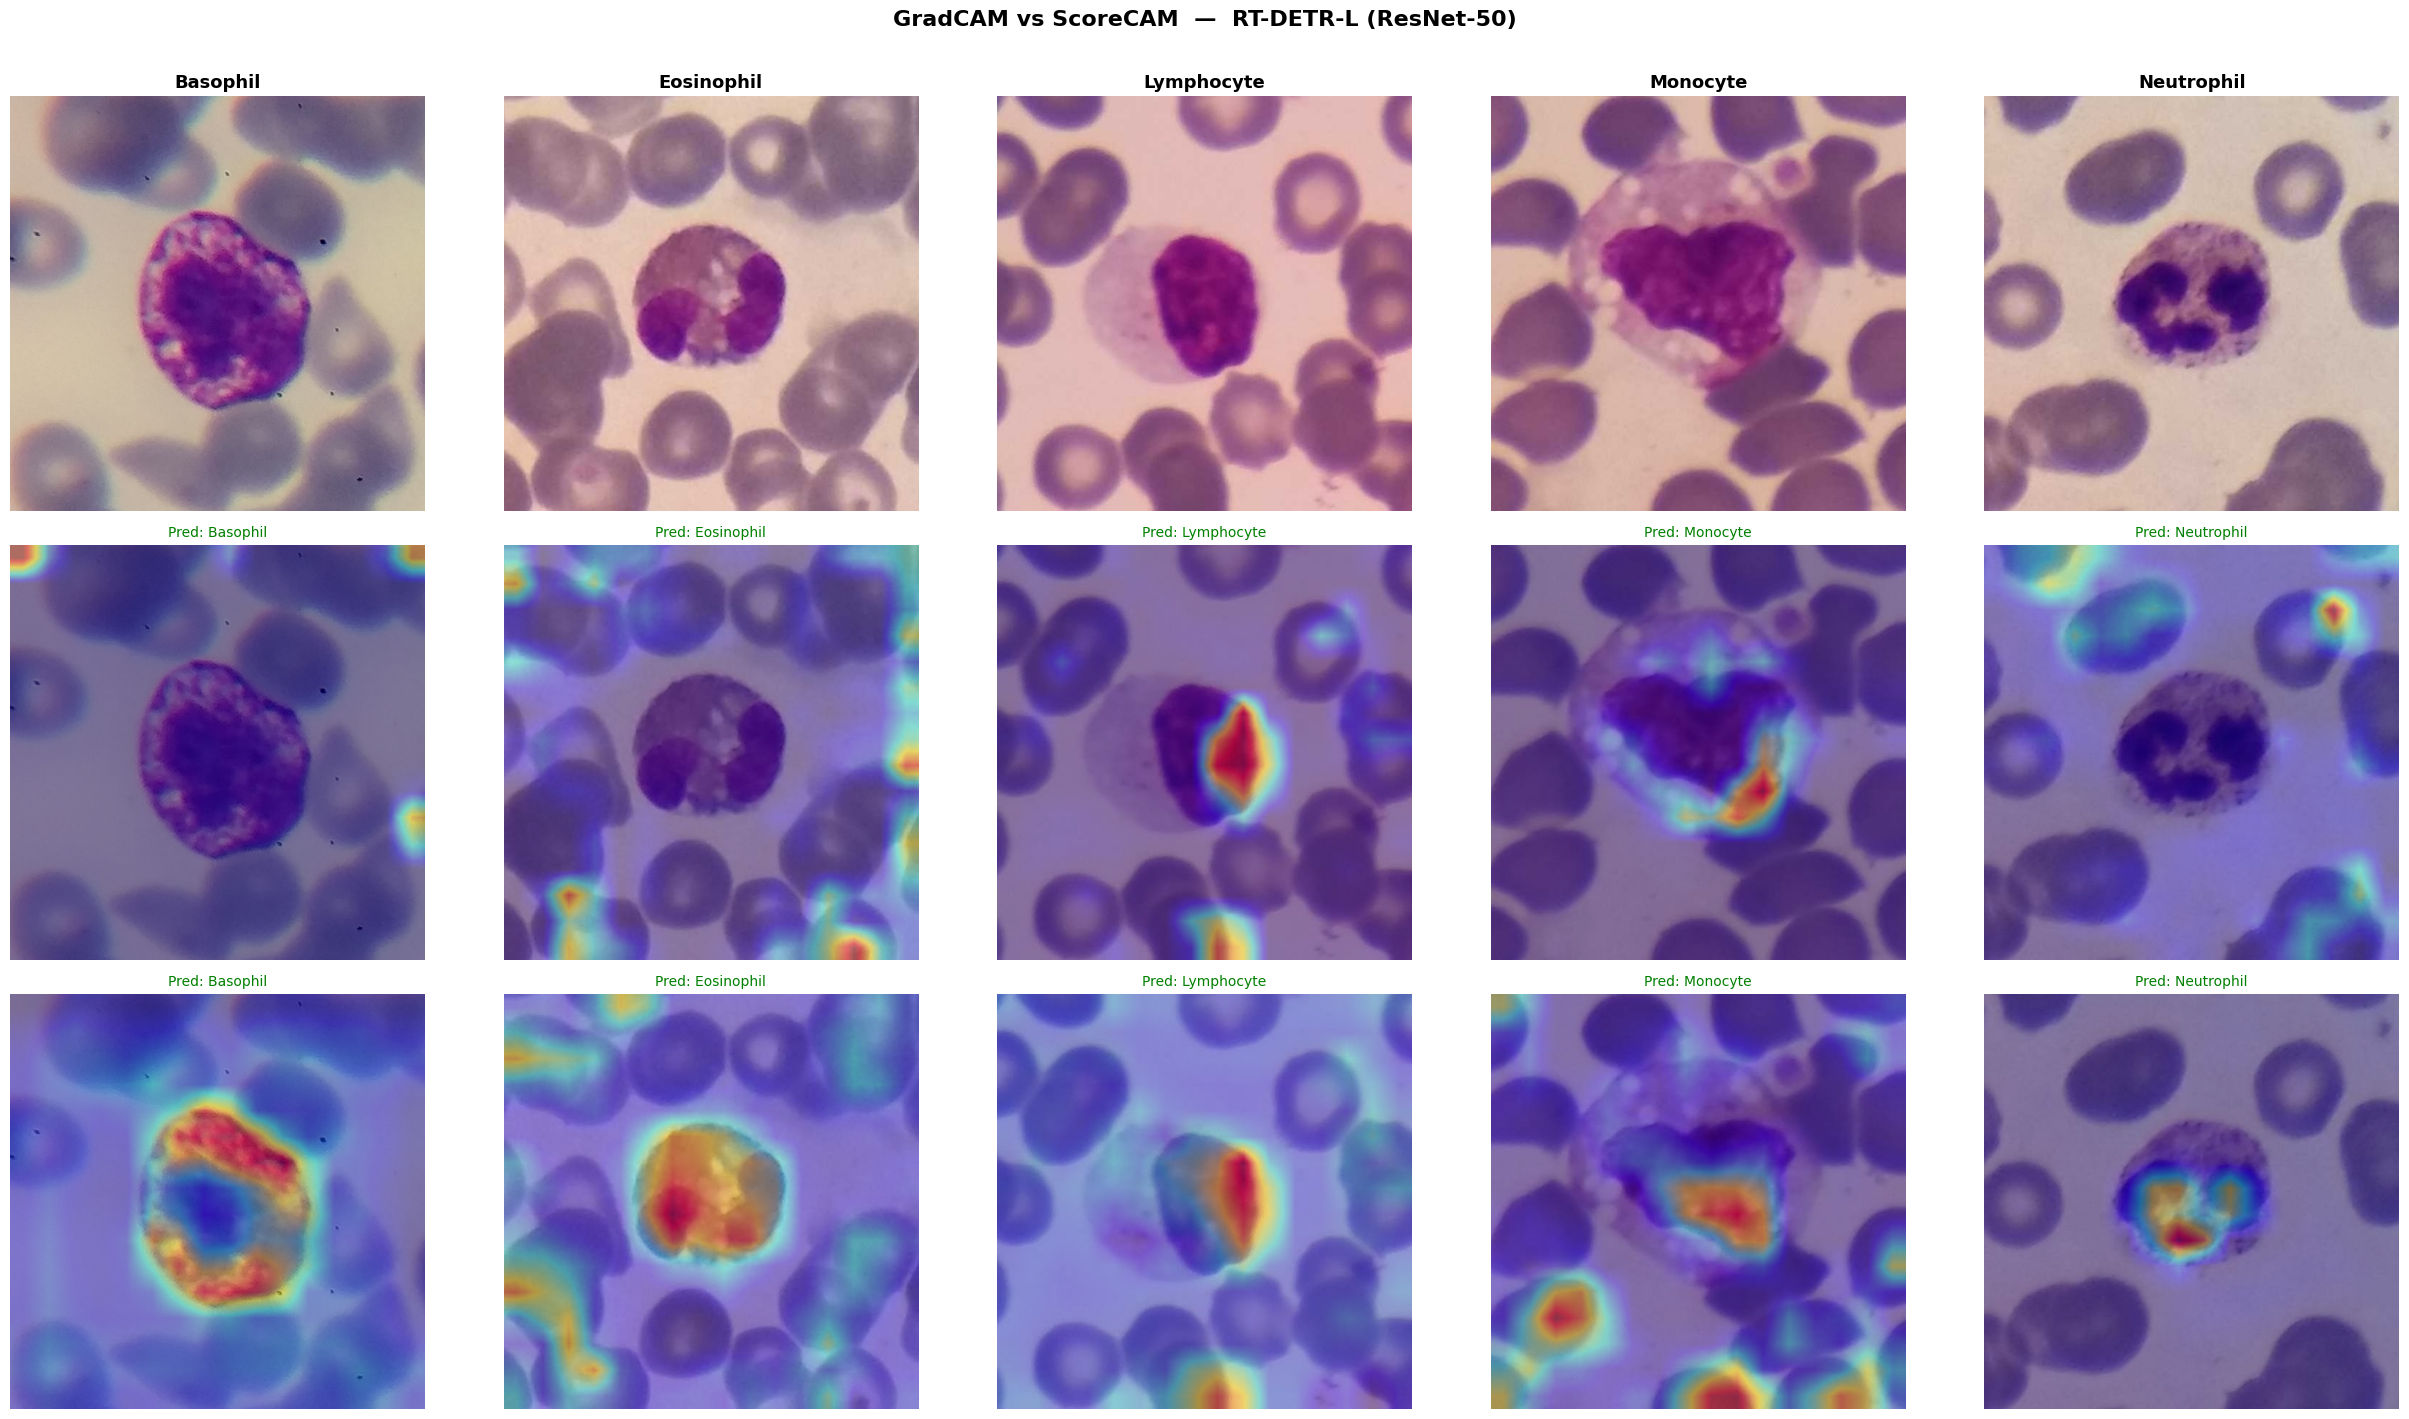

Saved: C:\D drive\mydata\MSML\GitHub\RT-DETR-Based-Explainable-CAD-System-for-Automated-Detection-and-Classification-of-White-Blood-Cells\output\results\gradcam_vs_scorecam_comparison.png


In [23]:
# =============================================================================
# 13.4  GradCAM vs ScoreCAM — Side-by-side Comparison (Best Model)
# =============================================================================
if gradcam_results and scorecam_results:
    # Use the model with best accuracy
    best = max(evaluation_results, key=lambda r: r["accuracy"])
    bname = best["model_name"]

    if bname in gradcam_results and bname in scorecam_results:
        fig, axes = plt.subplots(3, NUM_CLASSES, figsize=(5 * NUM_CLASSES, 14))
        fig.suptitle(
            f"GradCAM vs ScoreCAM  —  {bname} ({best['backbone']})",
            fontsize=16, fontweight="bold", y=1.01,
        )

        for i, cls_name in enumerate(CLASSES):
            g = gradcam_results[bname].get(cls_name)
            s = scorecam_results[bname].get(cls_name)

            # Row 0 – Original
            if g:
                axes[0, i].imshow(g[2])
            axes[0, i].set_title(cls_name, fontsize=13, fontweight="bold")
            axes[0, i].axis("off")
            if i == 0:
                axes[0, i].set_ylabel("Original", fontsize=12)

            # Row 1 – GradCAM
            if g and g[0] is not None:
                axes[1, i].imshow(g[0])
                pred = ID2LABEL.get(g[3], "?")
                color = "green" if pred == cls_name else "red"
                axes[1, i].set_title(f"Pred: {pred}", fontsize=10, color=color)
            else:
                axes[1, i].text(0.5, 0.5, "N/A", ha="center", va="center",
                                transform=axes[1, i].transAxes, fontsize=14)
            axes[1, i].axis("off")
            if i == 0:
                axes[1, i].set_ylabel("GradCAM", fontsize=12)

            # Row 2 – ScoreCAM
            if s and s[0] is not None:
                axes[2, i].imshow(s[0])
                pred = ID2LABEL.get(s[3], "?")
                color = "green" if pred == cls_name else "red"
                axes[2, i].set_title(f"Pred: {pred}", fontsize=10, color=color)
            else:
                axes[2, i].text(0.5, 0.5, "N/A", ha="center", va="center",
                                transform=axes[2, i].transAxes, fontsize=14)
            axes[2, i].axis("off")
            if i == 0:
                axes[2, i].set_ylabel("ScoreCAM", fontsize=12)

        plt.tight_layout()
        save_path = os.path.join(RESULTS_DIR, "gradcam_vs_scorecam_comparison.png")
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"Saved: {save_path}")
    else:
        print(f"Results not available for best model: {bname}")
else:
    print("Run the GradCAM and ScoreCAM cells above first.")